In [1]:
import library as l

import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import datetime
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
file='aggressive_dedup.json'
size = 40000
topsize = 300

seed1 = np.random.randint(size)
#seed2 = np.random.randint(size)
today = datetime.date.today()

savestring = 'seed_' + str(seed1) + '_size_' + str(size) + '_topsize_' + str(topsize) + '_date_' + str(today)

if not os.path.exists(savestring):
    os.makedirs(savestring)

2001 >>> 40000 [0.19 0.81]
2002 >>> 40000 [0.2 0.8]
2003 >>> 40000 [0.21 0.79]
2004 >>> 40000 [0.23 0.77]
2005 >>> 40000 [0.25 0.75]
2006 >>> 40000 [0.23 0.77]
2007 >>> 40000 [0.21 0.79]
2008 >>> 40000 [0.23 0.77]
2009 >>> 40000 [0.23 0.77]
2010 >>> 40000 [0.24 0.76]
2011 >>> 40000 [0.24 0.76]
2012 >>> 40000 [0.23 0.77]
2013 >>> 40000 [0.21 0.79]
2014 >>> 40000 [0.21 0.79]
['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'] [641057, 665193, 721220, 862542, 1192688, 1298316, 1959168, 2251645, 2884651, 3796743, 6044654, 11471413, 28000200, 19699868]


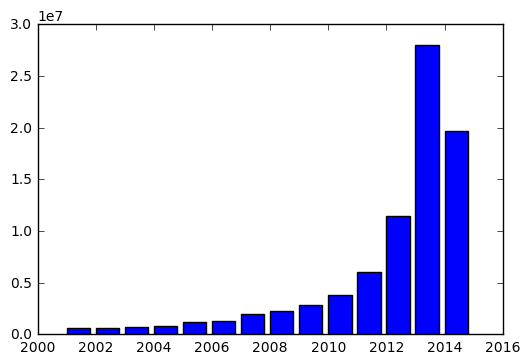

In [3]:
data, time, ratings, seen, indices = l.get_data(year='2001', size=size, limit=100000000)

l.save_file(savestring + '/indices.data', indices)
l.save_file(savestring + '/seen.data', seen)

l.simplify_ratings(data, ratings)
l.save_file(savestring + '/ratings.data', ratings)

#data2 = l.stopwords_filter(data)

l.selection_print(data, ratings)

x = sorted(list(data.keys()))
y = [seen.get(yr) for yr in x]
print(x, y)
plt.bar(x, y)
plt.show()
x = []
y = []

In [ ]:
LR = LogisticRegression(penalty='l1', n_jobs=-1, solver='saga', max_iter=300)
#LR = LogisticRegression(penalty='l1', n_jobs=-1, solver='saga', max_iter=100, class_weight='balanced')

CV = CountVectorizer(ngram_range=(1,2), analyzer='word', min_df=5) #, max_features=20000)

features = []
x = sorted(list(data.keys()))

In [ ]:
for i, key in enumerate(x):
    LR, CV = l.predict_scores(data[key], ratings[key], CV, LR, i, key, savestring, features)
    
    if i == 0:
        top_f = [[x,[len(features)-i]] for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features)))][:(-topsize - 1):-1]
        bot_f = [[x,[i+1]] for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features)))][:topsize]
    else:
        for i, m in enumerate(top_f):
            top_f[i][1] += [len(features)-i for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features))) if x == m[0]]
        for i, m in enumerate(bot_f):
            bot_f[i][1] += ([i+1 for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features))) if x == m[0]])

l.save_file(savestring + '/top_f.data', top_f)
l.save_file(savestring + '/bot_f.data', bot_f)

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.879625
2001
f1: [0.64267161 0.9276212 ]
recall: [0.55655527 0.95763501]
precision: [0.76031607 0.89943157]

0.867625
2002
f1: [0.63139575 0.91932658]
recall: [0.55884165 0.94621295]
precision: [0.7256     0.89392593]

0.868625
2003
f1: [0.65439    0.91889806]
recall: [0.58323564 0.9459803 ]
precision: [0.74531835 0.89332333]

0.856625
2004
f1: [0.64565956 0.91013085]
recall: [0.57010366 0.94178693]
precision: [0.74430199 0.88053366]

0.850375
2005
f1: [0.65907149 0.90415566]
recall: [0.59577755 0.93199076]
precision: [0.73741236 0.877935  ]



In [ ]:
for i in range(len(x)):
    print(sum([1/x[1][i] for x in top_f])/len(top_f))

In [ ]:
for i in range(len(x)):
    print(sum([1/x[1][i] for x in bot_f])/len(bot_f))

In [ ]:
len(bot_f)

In [ ]:
for i, m in enumerate(top_f):
    for j, n in enumerate(top_f[i][1]):
        if n > 1000:
            top_f[i][1][j] = 1000

In [ ]:
for i in range(15):
    temp = top_f[i][1]
    x = range(len(temp))
    y = temp
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    print('slope: ', m)
    plt.plot(x, y, 'o', label='Original data', markersize=10)
    plt.plot(x, m*x + c, 'r', label='Fitted line')
    plt.title(top_f[i][0])
    plt.show()